In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import tqdm
import os
import re

from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from PIL import Image

Set the device. Using CUDA on CUDA-enabled devices speeds up the use of convolutional networks significantly.

In [2]:
cuda_enabled = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_enabled else "cpu")

We will be using a random number generator every now and then throughout this notebook. By initializing it here, we can change a single seed to obtain the same/different results.

In [3]:
rng = np.random.default_rng(0)

We create the descriptors through transfer learning. We remove the last fully-connected (classification) layers of pre-trained models and use the output of the convolutional part of the respective model as descriptors. We do this for:

- VGG16

These models were chosen because of ... **TODO: List reasons for choosing models**

## Load datasets

Because the dataset contains images with a filename starting with a dot ("."), these files are hidden, giving problems down the line with reading. As such, rename them by adding "img" as a filename prefix.

In [4]:
base_path = "./data/Incidents-subset"
directories = os.listdir(os.path.expanduser(base_path))
for directory in directories:
    files = os.listdir(os.path.expanduser(base_path + "/" + directory))
    for file in files:
        if re.match(r".*.((jpg)|(png)|(jpeg))", file, re.IGNORECASE) and not re.match(r"img.*", file):
            os.rename(os.path.expanduser(base_path + "/" + directory + "/" + file), os.path.expanduser(base_path + "/" + directory + "/img" + file))

Some images are corrupted, so we need a check whether this is the case before images are added to the dataset. This is done by calling the function below in the `is_valid_file` parameter of the `ImageFolder` function.

In [5]:
def check_Image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

For transformation and normalization, we use the same parameter as used in the paper source code.

> Weber, E., Papadopoulos, D.P., Lapedriza, A., Ofli, F., Imran, M. and Torralba, A. 2022. Incidents1M: a large-scale dataset of images with natural disasters, damage, and incidents. arXiv.

Source code: https://github.com/ethanweber/IncidentsDataset.


In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])

data = torchvision.datasets.ImageFolder('./data/Incidents-subset', transform=transform, is_valid_file=check_Image)
targets = [target for (_, target) in data]
number_of_classes = len(data.classes)

/home/jovyan/2022-1B-DS-CIRI-Project/env/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Next, we split the data into a train and test set.

In [7]:
data_train, data_test = torch.utils.data.random_split(data, [0.7, 0.3])

targets_train = [target for (_, target) in data_train]
targets_test = [target for (_, target) in data_test]

dataloader_train = DataLoader(data_train, batch_size=4, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=4, shuffle=False)

## Visualise datasets

### General information

In [8]:
print(f"Number of items in dataset: {len(data)}")
print(f"Number of items in train set: {len(data_train)}")
print(f"Number of images in test set: {len(data_test)}")
print(f"Number of classes: {len(np.unique(targets))}")

Number of items in dataset: 7363
Number of items in train set: 5155
Number of images in test set: 2208
Number of classes: 12


### Class distribution

First, we assess the number of images per class in both the train and test set. This provides us with a rough idea of the distribution in the dataset.

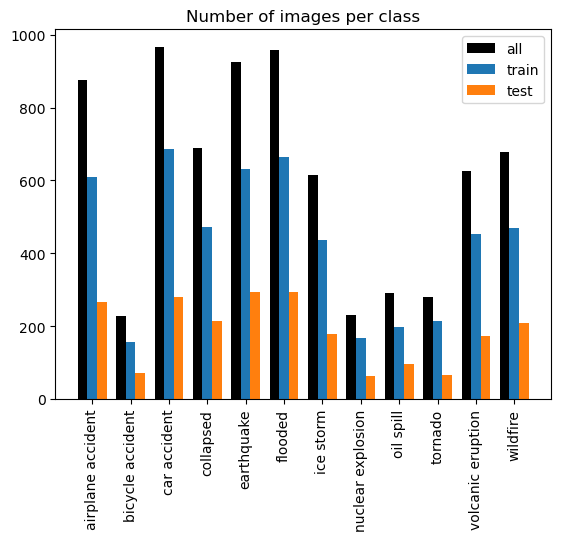

In [28]:
unique_targets, unique_target_counts = np.unique(targets, return_counts=True)
unique_targets_train, unique_target_counts_train = np.unique(targets_train, return_counts=True)
unique_targets_test, unique_target_counts_test = np.unique(targets_test, return_counts=True)

# Assert that train and test set both contain the same number of classes, as subsequent code relies on this assumption
assert len(unique_targets_train) == number_of_classes, "Train set must contain all classes"
assert len(unique_targets_test) == number_of_classes, "Test set must contain all classes"

# Convoluted way of showing a bar chart with multiple bars, but prevents having to create a dataframe for e.g. Seaborn
plt.bar(np.arange(number_of_classes) - 0.25,
        unique_target_counts,
        width=0.25,
        label="all",
        color="black")
plt.bar(np.arange(number_of_classes),
        unique_target_counts_train,
        width=0.25,
        # color="none",
        # edgecolor="black",
        # hatch="----",
        label="train")
plt.bar(np.arange(number_of_classes) + 0.25,
        unique_target_counts_test,
        width=0.25,
        # color="none",
        # edgecolor="black",
        label="test")
plt.xticks(np.arange(len(data.classes)),
           labels=data.classes,
           rotation="vertical")
plt.legend()
plt.title("Number of images per class")
plt.show()

The plot shows that the data in the dataset is unbalanced. For example, the "car accident" class sees a much larger occurence than the "nuclear explosion" class. This could lead to issues later on.

### Sample images

As a result of the normalization performed earlier, the images cannot be displayed as-is without clipping. Hence, we need a way to inverse the normalization before displaying the images. We do this through the use of a `Transform`.

In [10]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    Code from https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/8
    """
    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inverse_normalize = NormalizeInverse(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Now, we actually visualise the images.

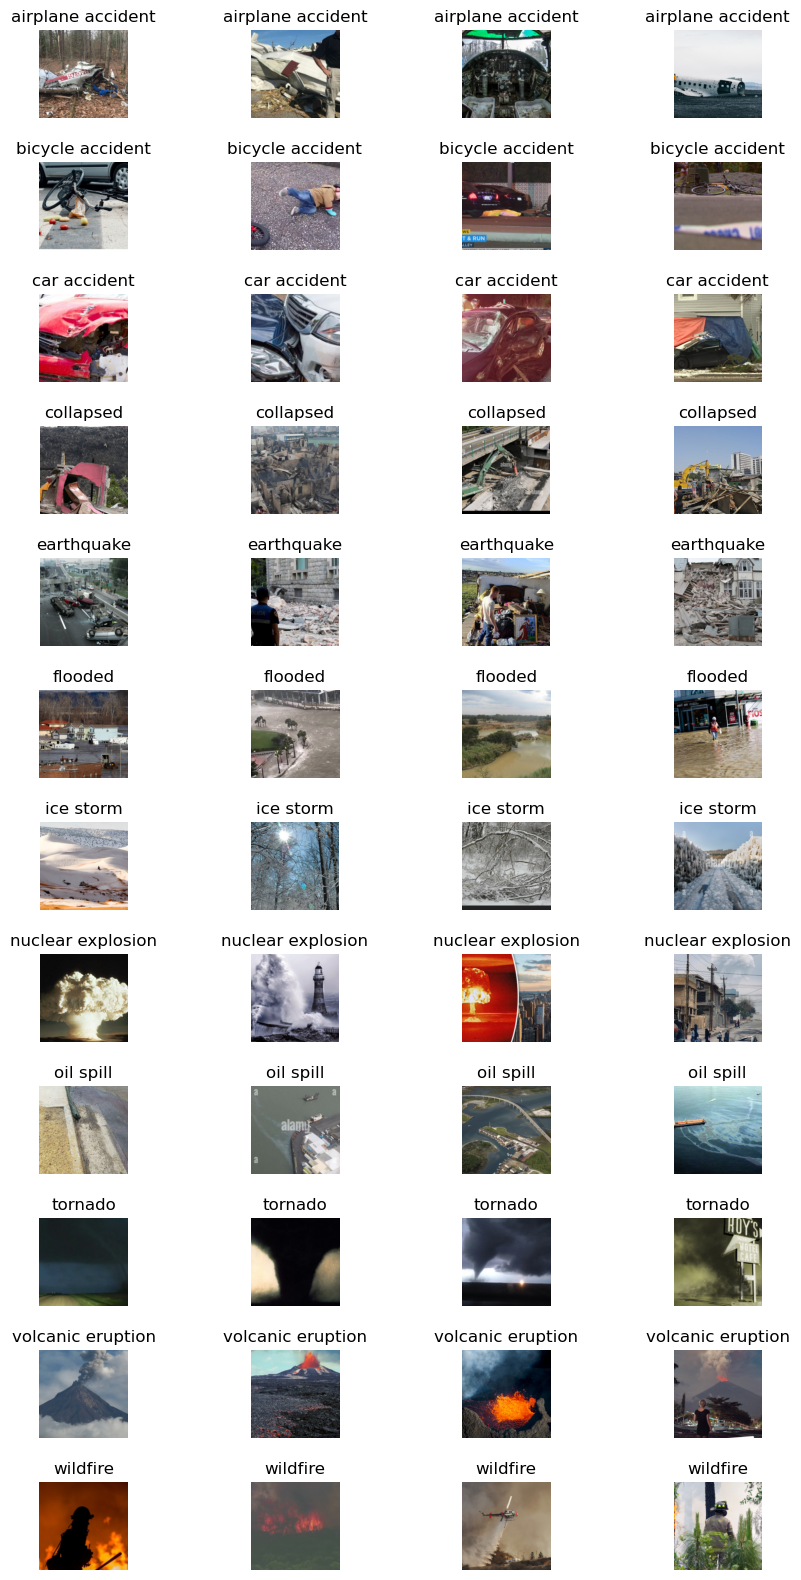

In [11]:
number_of_images_per_class = 4

# Create plots with sufficient size and spacing
fig, axs = plt.subplots(
    number_of_classes, number_of_images_per_class, figsize=(10, 20))
plt.subplots_adjust(hspace=.5, wspace=.5)

for target in range(0, len(data.classes)):
    # Create a mask for the dataset to include only images for this class
    relevant_image_indices = (np.array(targets) == target).nonzero()[0]
    
    # Randomly sample images from all relevant images
    sampled_image_indices = rng.choice(
        a=relevant_image_indices,
        size=number_of_images_per_class,
        replace=False
    )
    
    # Display the images with the proper title
    for i, image_index in enumerate(sampled_image_indices):
        ax = axs[target, i]
        ax.imshow(
            # Clamp to prevent values just outside the [0,1] range (as a result of inverse normalisation)
            torch.clamp(inverse_normalize(data[image_index][0]).permute(1,2,0), 0, 1),
            vmin=0,
            vmax=1)
        ax.axis("off")
        ax.set_title(data.classes[target])

## Initialize models

### VGG16

In [12]:
model_vgg16 = torchvision.models.vgg16(weights="DEFAULT")

for param in model_vgg16.parameters():
    # As the model will not be trained, gradients are not required. Disabling
    # them speeds up performance.
    param.requires_grad = False

# Set model to evaluation mode for reasons
# TODO: Check why model should be set to evaluation mode
model_vgg16.eval()

# Empty CUDA cache to prevent memory issues
if cuda_enabled:
    torch.cuda.empty_cache()

# Replace VGG16 classifier with identity layer to allow descriptor extraction
model_vgg16.classifier = nn.Identity()

# Move model to previously set device, speeding up performance if CUDA-enabled
model_vgg16 = model_vgg16.to(device)

## Baseline

### Obtain image descriptors

In [13]:
def get_descriptors_from_model(model, dataloader):
    """Returns the output of the provided model for all items in the dataloader."""
    outputs = []

    # Improve performance by disabling unnecessary gradient calculation
    with torch.no_grad():
        for data, targets in tqdm.tqdm(dataloader):
            data = data.to(device)
            output = model(data).detach()
            outputs.extend(output)

    return outputs


def transform_descriptors_to_numpy(descriptors):
    """Returns a numpy array derived from a provided list of tensors."""
    return np.array([descriptor.cpu().numpy() for descriptor in descriptors])

In [14]:
extract = True

descriptors_vgg16_train = None
descriptors_vgg16_test = None

if extract:
    descriptors_vgg16_train = transform_descriptors_to_numpy(
        get_descriptors_from_model(model_vgg16, dataloader_train))
    with open('data/descriptors_vgg16_train.bin', 'wb') as file:
        pickle.dump(descriptors_vgg16_train, file)
    
    descriptors_vgg16_test = transform_descriptors_to_numpy(
        get_descriptors_from_model(model_vgg16, dataloader_test))
    with open('data/descriptors_vgg16_test.bin', 'wb') as file:
        pickle.dump(descriptors_vgg16_test, file)
else:
    with open('data/descriptors_vgg16_train.bin', 'rb') as file:
        descriptors_vgg16_train = pickle.load(file)
    with open('data/descriptors_vgg16_test.bin', 'rb') as file:
        descriptors_vgg16_test = pickle.load(file)

100%|██████████| 552/552 [00:41<00:00, 13.32it/s]


### Perform k-nearest neighbors (kNN) classification

First, we define the number of neighbors using which we would like to perform classification.

In [40]:
n_neighbors_list = [2, 3, 5, 8, 13]

For each `n_neighbors` in the defined list, we perform classification and calculate the accuracy.

In [41]:
classifier_vgg16_per_n = {}
predictions_vgg16_train_per_n = {}
accuracy_vgg16_train_per_n = {}
predictions_vgg16_test_per_n = {}
accuracy_vgg16_test_per_n = {}

for n_neighbors in n_neighbors_list:
    classifier = KNeighborsClassifier(
        n_neighbors=n_neighbors
    ).fit(descriptors_vgg16_train, targets_train)
    classifier_vgg16_per_n[n_neighbors] = classifier

    predictions_train = classifier.predict(descriptors_vgg16_train)
    predictions_vgg16_train_per_n[n_neighbors] = predictions_train

    accuracy_train = accuracy_score(targets_train, predictions_train)
    accuracy_vgg16_train_per_n[n_neighbors] = accuracy_train

    predictions_test = classifier.predict(descriptors_vgg16_test)
    predictions_vgg16_test_per_n[n_neighbors] = predictions_test

    accuracy_test = accuracy_score(targets_test, predictions_test)
    accuracy_vgg16_test_per_n[n_neighbors] = accuracy_test

### Assess performance of kNN-classification for various values of n

We assess the accuracies calculated before.

Accuracy on training set for 2-neighbor classification: 0.8578
Accuracy on training set for 3-neighbor classification: 0.6012
Accuracy on training set for 5-neighbor classification: 0.4417
Accuracy on training set for 8-neighbor classification: 0.3732
Accuracy on training set for 13-neighbor classification: 0.3065
Accuracy on test set for 2-neighbor classification: 0.2939
Accuracy on test set for 3-neighbor classification: 0.2803
Accuracy on test set for 5-neighbor classification: 0.2717
Accuracy on test set for 8-neighbor classification: 0.2577
Accuracy on test set for 13-neighbor classification: 0.2491


Text(0, 0.5, 'accuracy')

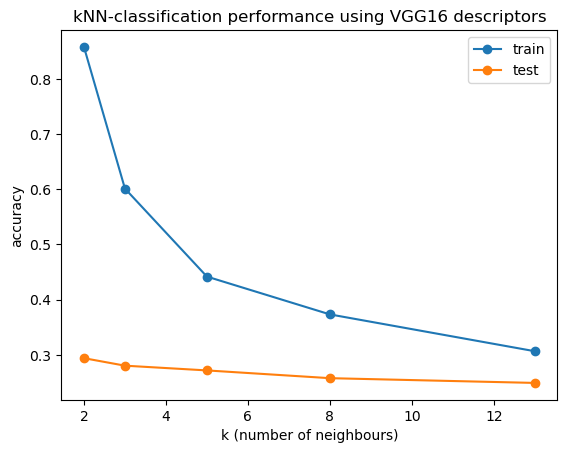

In [42]:
for n_neighbors in n_neighbors_list:
    train_accuracy = round(accuracy_vgg16_train_per_n[n_neighbors], 4)
    print(f"Accuracy on training set for {n_neighbors}-neighbor classification: {train_accuracy}")

for n_neighbors in n_neighbors_list:
    test_accuracy = round(accuracy_vgg16_test_per_n[n_neighbors], 4)
    print(f"Accuracy on test set for {n_neighbors}-neighbor classification: {test_accuracy}")

plt.plot(n_neighbors_list,
         list(accuracy_vgg16_train_per_n.values()),
         label="train",
         marker="o")
plt.plot(n_neighbors_list,
         list(accuracy_vgg16_test_per_n.values()),
         label="test",
         marker="o")
plt.legend()
plt.title("kNN-classification performance using VGG16 descriptors")
plt.xlabel("k (number of neighbours)")
plt.ylabel("accuracy")

The plot shows that the accuracy on the test set is quite stable, at a level just below 0.3. Meanwhile, the accuracy on the training set drops significantly as the number of neighbors is increased.

### Visually assess predicted vs. target through PCA

In [43]:
best_n_train = max(accuracy_vgg16_train_per_n, key=accuracy_vgg16_train_per_n.get)
best_n_test = max(accuracy_vgg16_test_per_n, key=accuracy_vgg16_test_per_n.get)

In [44]:
pca_train = PCA(n_components=2).fit_transform(descriptors_vgg16_train)
pca_test = PCA(n_components=2).fit_transform(descriptors_vgg16_test)

In [70]:
def plot_predictions_against_targets(data,
                                     predictions,
                                     targets,
                                     n_classes,
                                     cmap=None):
    """Draws a scatter plot of two-dimensional data which highlights
    differences between targets and predictions through distinct edge and fill
    colors."""

    if cmap is None:
        cmap = plt.get_cmap("rainbow")

    if isinstance(targets, list):
        targets = np.array(targets)

    colors_target = cmap(targets / n_classes)
    colors_predictions = cmap(predictions / n_classes)

    fig, ax = plt.subplots()
    # Plot targets (ground truth) with fill color representing target class
    ax.scatter(data[:, 0],
               data[:, 1],
               facecolors=colors_target,
               label="target")

    # Plot predictions with edge color representing predicted class
    ax.scatter(data[:, 0],
               data[:, 1],
               facecolors="none",
               edgecolors=colors_predictions,
               label="predicted")

    legend = ax.legend()
    # Set colors to black to indicate the legend is about marker type, rather
    # than color
    legend.legendHandles[0].set_color("black")
    legend.legendHandles[1].set_edgecolor("black")

    return (fig, ax)

Text(0.5, 1.0, 'Two-component PCA, test data')

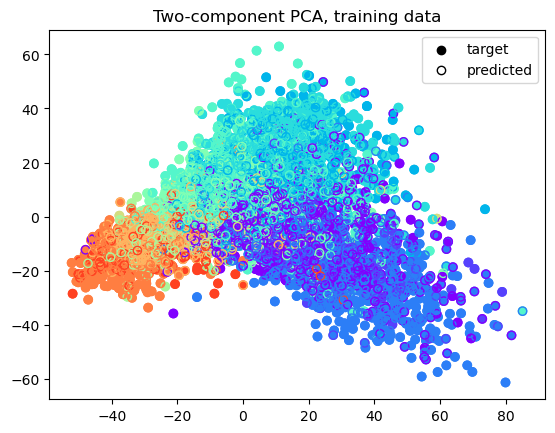

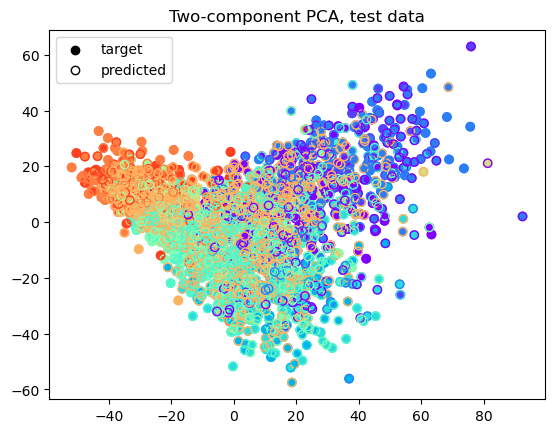

In [71]:
_, ax_train_scatter = plot_predictions_against_targets(pca_train,
                                                       predictions_vgg16_train_per_n[best_n_train],
                                                       targets_train,
                                                       number_of_classes)
ax_train_scatter.set_title("Two-component PCA, training data")

_, ax_test_scatter = plot_predictions_against_targets(pca_test,
                                                      predictions_vgg16_test_per_n[best_n_test],
                                                      targets_test,
                                                      number_of_classes)
ax_test_scatter.set_title("Two-component PCA, test data")